In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from constants import numeric_columns as num_cols

#in titanic
#   import math

In [264]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import DBSCAN

#in titanic fa con scipy
    #from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

#vedere se serve
#evaluation
from sklearn.metrics import silhouette_score

#vedere se serve
#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform


In [265]:
df = pd.read_csv("pp_train.csv")
df.head()

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,worstRating,bestRating,totalImages,...,is_War,is_Sci-Fi,is_Talk-Show,is_Adventure,is_Film-Noir,is_Music,is_Western,is_Comedy,is_Drama,fill_runtimeMinutes
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,NaN,NaN,0.0,779,1,10,1,...,0,0,0,1,0,0,0,0,0,40.0
1,Looping,6,1982,NaN,NaN,0.0,11,1,10,1,...,0,0,0,0,0,0,0,0,0,28.0
2,Idealnaya para,6,1992,NaN,NaN,0.0,38,1,10,1,...,0,0,0,0,0,0,0,1,0,90.0
3,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,1,10,22,...,0,0,0,0,0,0,0,0,0,31.0
4,Seutateueob,8,2020,2020.0,80.0,1.0,15718,1,10,347,...,0,0,0,0,0,0,0,1,1,80.0


In [266]:
df["titleType"].unique()

array(['tvEpisode', 'videoGame', 'movie', 'tvSeries', 'video',
       'tvMiniSeries', 'short', 'tvMovie', 'tvSpecial', 'tvShort'],
      dtype=object)

In [267]:
#columns 
#   'startYear', 'runtimeMinutes', 'awardWins', 'numVotes', 'totalImages',
#   'totalVideos', 'totalCredits', 'criticReviewsTotal', 'awardNominationsExcludeWins',
#   'numRegions', 'userReviewsTotal','ratingCount'
# ????
#   'rating', 'canHaveEpisodes', 'isAdult', 'genres' (as 1henc or as a count?)

In [268]:
features = df[['startYear', 'fill_runtimeMinutes', 'awardWins', 'numVotes', 'totalImages','totalVideos', 'totalCredits', 'criticReviewsTotal', 'awardNominationsExcludeWins','numRegions', 'userReviewsTotal','ratingCount']]
X = features.values

In [269]:
#presuppongo di voler fare poi i controlli cluster in abse a titletype
y = np.array(df['titleType']) 
#a way to define x and y; they are the numpy arrays of the dataset

y_map = {
    0: 'tvEpisode',
    1: 'videoGame',
    2: 'movie',
    3: 'tvSeries',
    4: 'video',
    5: 'tvMiniSeries',
    6: 'short',
    7: 'tvMovie',
    8: 'tvSpecial',
    9: 'tvShort'
}
y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)
#y is our target label; mapped into strings (y_map)

### Normalizations 

In [270]:
## Sklearn -> inizializza metodo, fit su dati che abbiamo, transform/predict in base al metodo

In [271]:
# z-score, fit and then transform
scaler = StandardScaler()   #inizialize the standard scaler
scaler.fit(X) #fit the scaler on the data; x è la numpy matrix of the dataset
X_scal = scaler.transform(X) #transform to have the scaled version

In [272]:
# min-max, fit and trasform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X) #fit e scaler in una riga sola

## DBSCAN

In [273]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan.fit(X_minmax)

#initiialize and fit into data --> procedura che faremo anche noi

DBSCAN(eps=0.3)

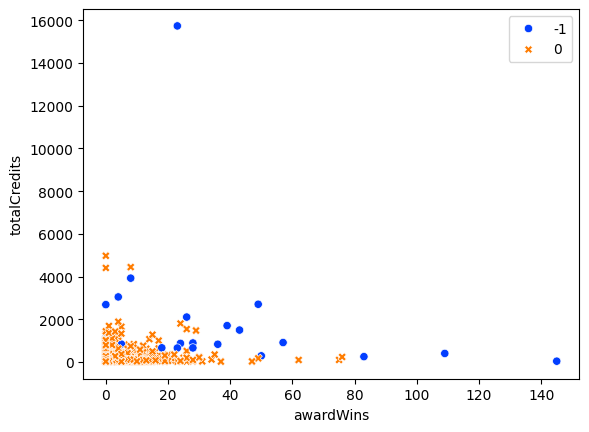

In [274]:
sns.scatterplot(data=df,
                x="awardWins", 
                y="totalCredits", 
                hue=dbscan.labels_, 
                style=dbscan.labels_, 
                palette="bright")
plt.show()


In [275]:
np.unique(dbscan.labels_, return_counts=True)
#to have the classification of the different clusters (messi dopo -> -1 è il noise) e quanti points in ogni cluster

(array([-1,  0], dtype=int64), array([   28, 16403], dtype=int64))

In [276]:
dbscan.labels_

#possiamo accedere alle label-> possiamo fare quello che vogliamo

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [277]:
# counting silhouette also w.r.t to noise cluster (-1)
#   print('Silhouette', silhouette_score(X_minmax, dbscan.labels_)) 

#considering DBSCAN but not noise cluster
#   print('Silhouette', silhouette_score(X_minmax[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])) 

#when we measure silh. on DBSCAN labels we would count the silh. also with respect to noise cluster (-1)
#se non si considerano il noise cl. la silhouette è higher perchè noise points are far and so this influences silh. due to the long distances  
#so everytime that we measure the silhouette for DBSCAN scartiamo anche noise così misuriamo risultato solo sui cluster

### kth neighbor distance

In [278]:
#misuro distanze dal kth nearest n. -> usando pairwise distance da ogni pt (ptovo con eucl)
dist = pdist(X_minmax, 'euclidean') 
dist = squareform(dist)

#risultato -> array compresso con distanze per ogni coppia di punti nel dataset.

In [279]:
#chat
#   k = 4  # Numero di vicini da considerare
#   k_distances = np.sort(dist, axis=1)[:, k]  # Prendi la distanza del k-esimo vicino

In [280]:
#chat
#   plt.plot(np.sort(k_distances))
#   plt.xlabel('Points')
#   plt.ylabel(f'{k}-th Nearest Neighbor Distance')
#   plt.title('Elbow Method for DBSCAN')
#   plt.show()

In [281]:
k=4
kth_distances = []

for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list

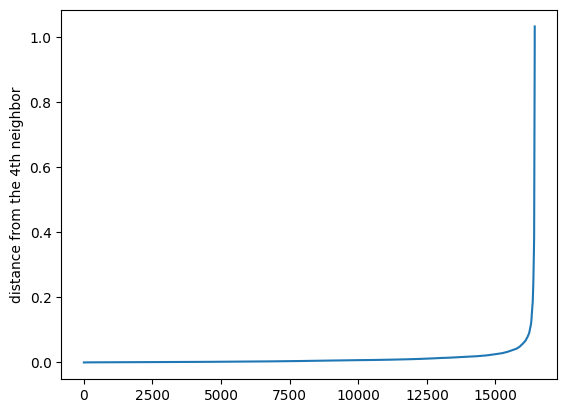

In [282]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
         
plt.show()

KeyboardInterrupt: 

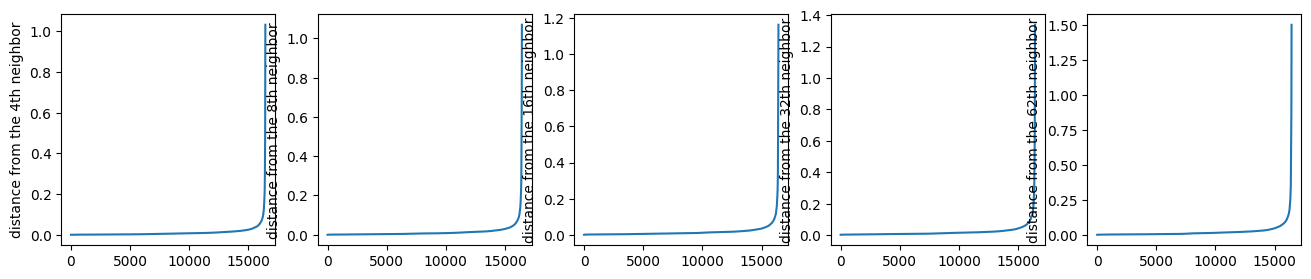

In [283]:
#dobbiamo farlo non solo con il quarto -> helpful if the data is larger
#infatti nell'ultimo, usando il 62 -> if we consider clustering by using 62 points for a point to be considered as a core point vediamo i due cluster
ks = [4, 8, 16, 32, 62]


fig = plt.figure(figsize=(16, 3)) # dimensions of the overall plot
fig_dims = (1, len(ks))

for i in range(len(ks)):
    k = ks[i]
    kth_distances = []

    for d in dist:  # d is a vector containing distances between the ith record and all the others
        index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
        kth_distances.append(d[index_kth_distance])  # store the distance in a list

    plt.subplot2grid(fig_dims, (0, i))
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('distance from the {}th neighbor'.format(k))
             
plt.tight_layout()
plt.show()